In [2]:
#Mount drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#install fast ai
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

In [0]:
#import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [112]:
#get biopaper data 
trainCsvPath = Path('drive/My Drive/Year5/csc4006 Final Project/data/bioPaperExport_text_label.csv')
preDf = pd.read_csv(trainCsvPath)
preDf.shape

(29319, 2)

In [0]:
textPath = 'drive/My Drive/Year5/csc4006 Final Project/data/'
textCsv = 'bioPaperExport_text_label.csv'

In [114]:
#Split each abstract into sentences
##use tokeniser below instead
df = pd.DataFrame(columns=['text','label'])
sList = []
for i,row in preDf.iterrows():
  text = row['text']
  label = row['label']
  sent = text.split('. ')
  sentences = [s.strip() for s in sent]
  sentences = list(filter(None,sentences))
  for s in sentences:
    sList.append((label,s))
    
#sList = ('label','text') + sList
#print(sList[:2])
df = pd.DataFrame(sList,columns=['label','text'])
df.shape
  
  
  


(257739, 2)

In [0]:
df.label.unique()
all_labels = ['neuroscience', 'cancer biology', 'cell biology', 'bioengineering', 'molecular biology', 'biochemistry',
       'developmental biology', 'biophysics', 'systems biology', 'plant biology', 'evolutionary biology', 'zoology',
       'bioinformatics', 'animal behavior and cognition', 'ecology', 'genomics',
       'scientific communication and education', 'genetics', 'immunology', 'pharmacology and toxicology',
       'microbiology', 'physiology', 'epidemiology', 'synthetic biology', 'clinical trials', 'pathology',
       'paleontology', 'unknown']

small_categories = ['bioengineering','animal behavior and cognition','physiology','synthetic biology','pharmacology and toxicology',
                    'scientific communication and education','pathology','zoology','clinical trials','paleontology','unknown']


In [116]:
#using nltk to split by sentences
#use punkt sentence tokenizer

import nltk
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

ab01 = 'The emergence of multicellularity requires the coexistence of diverse cellular populations displaying cooperative relationships. This enables long-term persistence of cellular consortia, particularly under environmental constraints that challenge cell survival. Toxic environments are known to trigger the formation of multicellular consortia capable of dealing with waste while promoting cell diversity as a way to overcome selection barriers. In this context, recent theoretical studies suggest that an environment containing both resources and toxic waste can promote the emergence of complex, spatially distributed proto-organisms exhibiting division of labor and higher-scale features beyond the cell-cell pairwise interactions. Some previous non-spatial models suggest that the presence of a growth inhibitor can trigger the coexistence of competitive species in an antibiotic-resistance context. In this paper we further explore this idea using both mathematical and computational models taking the most fundamental features of the proto-organisms interactions. It is shown that this resource-waste environmental context, in which both species are lethally affected by the toxic waste and metabolic tradeoffs are present, favours the maintenance of diverse populations. A spatial, stochastic extension confirms our basic results. The evolutionary and ecological implications of these results are outlined.'
sentences = tokenizer.tokenize(ab01)
print(sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['The emergence of multicellularity requires the coexistence of diverse cellular populations displaying cooperative relationships.', 'This enables long-term persistence of cellular consortia, particularly under environmental constraints that challenge cell survival.', 'Toxic environments are known to trigger the formation of multicellular consortia capable of dealing with waste while promoting cell diversity as a way to overcome selection barriers.', 'In this context, recent theoretical studies suggest that an environment containing both resources and toxic waste can promote the emergence of complex, spatially distributed proto-organisms exhibiting division of labor and higher-scale features beyond the cell-cell pairwise interactions.', 'Some previous non-spatial models suggest that the presence of a growth inhibitor can trigger the coexistence of competitive species in an ant

In [0]:

df = pd.DataFrame(columns=['text','label'])
sList = []
for i,row in preDf.iterrows():
  text = row['text']
  label = row['label']
  sentences = tokenizer.tokenize(text)
   
  for s in sentences:
    sList.append((label,s))


In [118]:
df = pd.DataFrame(sList,columns=['label','text'])
df.shape

(252971, 2)

In [0]:
df.text.sort_values()

In [0]:
df.label.unique()

In [0]:
from google.colab import files
output = [x[1] for x in sList]
with open('sentences_out.txt', 'w+') as f:
    for item in output:
        f.write("%s\n" % item)

files.download('sentences_out.txt')       

In [121]:
lSent = df.loc[df['text'].str.len() >= 100]
lSent.shape

df = lSent
df.shape


(215498, 2)

In [122]:
#Find average length
df.apply(lambda x: np.mean(x.str.len())).reset_index(name='mean_len_text')

,index,mean_len_text
0,label,13.088938
1,text,177.857080


In [123]:
#check sizes of each category
df.label.value_counts()

neuroscience                              40323
bioinformatics                            20279
microbiology                              19080
genomics                                  14230
evolutionary biology                      13879
genetics                                  12007
cell biology                               9706
ecology                                    9327
biophysics                                 8511
cancer biology                             7199
epidemiology                               7116
developmental biology                      6656
molecular biology                          6494
systems biology                            6123
biochemistry                               5672
plant biology                              5670
immunology                                 5090
bioengineering                             3996
animal behavior and cognition              3651
physiology                                 2492
synthetic biology                       

In [130]:
##Test binary classification for categories: bioinformatics, microbiology
df = pd.concat([df[df.label == 'bioinformatics'],df[df.label == 'microbiology']])
#df.shape
#df.label.unique()
df.label.value_counts()

bioinformatics    20279
microbiology      19080
Name: label, dtype: int64

In [0]:
##Save binary df
from google.colab import files
binary_cat = 'sentences_2_categories.csv'
df.to_csv(binary_cat, encoding='utf-8')
files.download(binary_cat)    

In [0]:
##Remove categories less than 5000

for lb in df.label.unique():
  if(df[df.label == lb].shape[0] < 5000):
    df = df[df.label != lb]
    print('remove',lb,'new df',df.shape)



In [48]:
##Sample 5000 rows for each category
##Use sample_df
sampled_df = pd.DataFrame(columns=['label','text'])
for lb in df.label.unique():
  sample_category_df = df[df.label == lb].sample(n=5000)
  sampled_df = pd.concat([sampled_df,sample_category_df])
  
print(sampled_df.label.value_counts())

bioinformatics           5000
systems biology          5000
developmental biology    5000
epidemiology             5000
cell biology             5000
evolutionary biology     5000
cancer biology           5000
microbiology             5000
immunology               5000
genetics                 5000
biophysics               5000
neuroscience             5000
ecology                  5000
biochemistry             5000
genomics                 5000
plant biology            5000
molecular biology        5000
Name: label, dtype: int64


In [0]:
##Save sampled sentences
from google.colab import files
sampled_sentences_file = 'sentences_5000_per_category.csv'
sampled_df.to_csv(sampled_sentences_file, encoding='utf-8')
files.download(sampled_sentences_file)    

In [55]:
sampled_df.label.unique()
print(sampled_df.label.value_counts())

bioinformatics           5000
systems biology          5000
developmental biology    5000
epidemiology             5000
cell biology             5000
evolutionary biology     5000
cancer biology           5000
microbiology             5000
immunology               5000
genetics                 5000
biophysics               5000
neuroscience             5000
ecology                  5000
biochemistry             5000
genomics                 5000
plant biology            5000
molecular biology        5000
Name: label, dtype: int64


In [0]:
a = smallSent.shape[0]
b = df.shape[0]

a/b*100


6.686141889781832

In [137]:
#Split data into training/testing sets
from sklearn.model_selection import train_test_split
trainDf, testDf = train_test_split(df,stratify=df['label'], test_size = 0.2, random_state = 11)

trainDf.shape,testDf.shape

((31487, 2), (7872, 2))

In [0]:
#create models from data 
data_lm = TextLMDataBunch.from_df(train_df=trainDf,valid_df=testDf,path='',text_cols='text', label_cols='label')

In [139]:
data_lm.show_batch()

idx,text
0,"those dogs which had not yet been fed that food . xxbos xxmaj while a number of approaches were successful in terms of discovering complementary trait - associated modules , consensus predictions derived from the challenge submissions performed best . xxbos xxmaj during an xxmaj australian outbreak of hpev in the summer of 2013 , we performed xxup pcr - based screening and genotyping to determine whether ill xxmaj queensland"
1,"component analysis revealed variation by treatment with the first two principal components corresponding to headspace gas ( xxup co2 or xxup n2 ) and pressure ( 1 atm and 100 atm ) , respectively . xxbos xxmaj stochastic factors mostly affected rare members of the communities and caused the microbial community structure to diverge in one of the reactors ; however , this did not have an impact on the"
2,assessment of activity . xxbos xxmaj living cells are highly complex systems comprising a multitude of elements that are engaged in the many convoluted processes observed during the cell cycle . xxbos xxmaj conclusions : xxmaj the improved long - range phasing and haplotype library imputation algorithms enable alphaphase to quickly and accurately phase very large and heterogeneous datasets . xxbos xxmaj the unbiasedly estimating proportion of immune and stromal
3,"test drug effectiveness for prep . xxbos xxmaj despite dozens of algorithms developed to address this problem in genomics research , methods with improved accuracy and speed are still needed to effectively tackle both existing and emerging genomic and epigenomic segmentation problems . xxbos a qpcr assay targeting the hgca sequence in three main clades ( xxmaj deltaproteobacteria , xxmaj firmicutes and xxmaj archaea ) was used in the field"
4,"using relatively easily obtainable large tissue - level data . xxbos xxmaj re - introduction of the xxmaj gram - negative commensal bacterium xxmaj xxunk xxunk into a germ - free host is sufficient to restore xxup t6ss - dependent pathogenesis . xxbos xxmaj on eight published datasets , cross - talk rates are estimated to range from 0.4 % to 1.5 % mis - assigned reads . xxbos xxmaj"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [141]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02


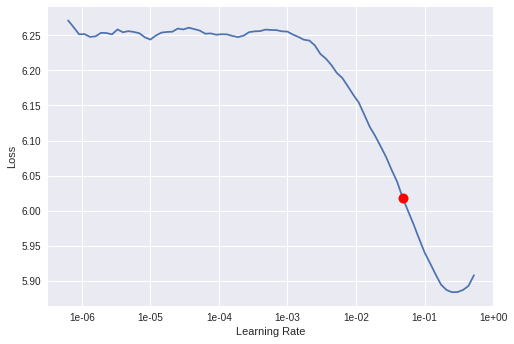

In [142]:
#learn.recorder.plot(skip_end=15)
learn.recorder.plot(suggestion=True,skip_end=15)


In [143]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0478630092322638

In [144]:
#learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
##Using suggested lr
learn.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,accuracy,time
1,4.560251,4.169877,0.315021,01:51
2,4.027056,4.031365,0.325181,01:51


In [0]:
#save 
learn.save('bio3_punkt_fit_head')

In [0]:
learn.load('bio3_punkt_fit_head')

In [0]:
learn.unfreeze()

In [77]:
#finetuning
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
1,5.035957,4.812103,0.275908,05:22


In [0]:
learn.save('fine_tuned_1_epoch')

In [0]:
learn.load('fine_tuned_1_epoch');

In [146]:
TEXT = "Ryan is a boy"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Ryan is a boy ( 24 m ) high - angle , single - angle , coil , 1.1 x 18 x 16 x 20 nm long Rod . xxbos In the source code , a custom NGS set of samples
Ryan is a boy molecule that uses a powerful statistical framework to predict the distribution of bonds in divergence and impact of soil structure and the roles of the cell wall . xxbos In this study , we present a pipeline called


In [0]:
data_clas = TextClasDataBunch.from_df(path='',train_df=trainDf, valid_df=testDf, vocab=data_lm.train_ds.vocab,text_cols='text', label_cols='label')

In [0]:
learn.save_encoder('fine_tuned_enc')

In [148]:
data_clas.show_batch()

text,target
"xxbos xxmaj specifically , xxup omega : 1 ) imports image data and metadata from data management tools such as xxmaj open xxmaj microscopy xxmaj environment xxmaj remote xxmaj objects ( xxup xxunk ; xxmaj allan et al . , 2012 ) ; 2 ) tracks intracellular particles moving across time series of image planes ; 3 ) facilitates parameter optimization and trajectory results inspection and validation ; 4 )",bioinformatics
"xxbos xxmaj inducible xxup no synthase ( inos ) inhibition by dexamethasone promoted an increase in the survival rate of xxup p. berghei - infected mice and data suggested the participation of oxidative stress in brain as a result of plasmodial infection , as well as the inhibition of brain xxup no synthesis , which promoted survival rate of almost 90 % of the animals until the xxunk day of",microbiology
xxbos xxmaj in particular the universal enrichment of negative charge and the larger than average xxup ses area for a polar atom on the surface of a water - soluble protein suggest that from a protein - solvent interaction perspective to fold into a native state is to optimize the electrostatic and hydrogen - bonding interactions between solvent molecules and the surface polar atoms of a protein rather than to,bioinformatics
"xxbos xxmaj using two sets of xxmaj escherichia coli persister cells , those arising naturally at low levels and those generated at high levels by ceasing transcription via rifampicin pretreatment ( shown to be bona fide persisters through seven sets of experiments ) , we used microscopy of single cells to determine that persisters have low levels of antibiotic - corrupting proteins and that their resuscitation is heterogeneous and includes",microbiology
"xxbos xxmaj the resulting xxmaj genome xxmaj wide xxmaj association xxmaj study networks , integrated with xxmaj single xxmaj nucleotide xxmaj polymorphism ( xxup snp ) correlation , co - methylation and co - expression networks through the xxup loe scores are proving to be a powerful approach to determine the pleiotropic and epistatic relationships underlying cellular functions and , as such , the molecular basis for complex phenotypes ,",bioinformatics


In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [163]:
learn.lr_find()

ValueError: ignored

Min numerical gradient: 5.75E-06


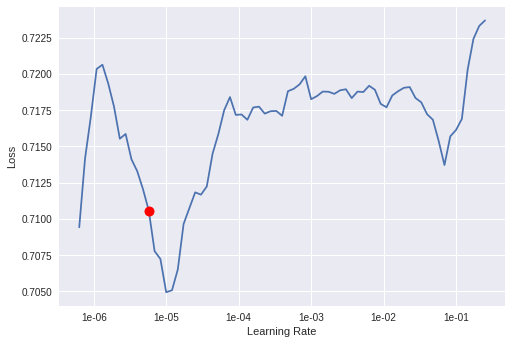

In [161]:
learn.recorder.plot(suggestion=True,skip_end=15)

In [164]:
learn.fit_one_cycle(1, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
1,45.529350,76.158829,0.515244,01:07


In [162]:
learn.freeze_to(-2)
learn.fit_one_cycle(1,2e-6, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.715875,0.702823,0.514609,01:08


In [0]:
learn.save('bio03_second')

In [0]:
learn.fit_one_cycle(4, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,1.918812,1.691700,0.494828
2,1.820812,1.623219,0.514219
3,1.729591,1.579311,0.528520
4,1.708868,1.559606,0.533848


In [0]:
learn.save('bio03_third_5cycle')

In [0]:
from google.colab import files


files.download('content/models/bio03_third_5cycle.pth')   

FileNotFoundError: ignored